In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('..')

In [2]:
%load_ext autoreload
%autoreload 2

## MV-CTR

The joint distribution is given by:

$$
P(f, z, \Phi, \theta | \alpha, \beta)
    = \prod_{t=1}^T \prod_{k=1}^K
    P(\theta_k | \alpha) P(z_{kt} | \theta_k) \prod_{x=1}^V  P(\Phi_{kx} | \beta_x) P(f_{tx} | z_{kt}, \Phi_{kx}) \\
    = \prod_{k=1}^K \theta_k^{\sum_{t=1}^T z_{kt} + \alpha_k - 1} \prod_{x=1}^V  (\Phi_{kx})^{\sum_{t=1}^T f_{tx}z_{kt} + \beta_x - 1} 
$$

Marginalizing over $\theta$ and $\Phi$ gives:

$$
    P(f, z | \alpha, \beta) = \int P(f, z, \Phi_t, \theta | \alpha, \beta) d\theta d\Phi \\
        = \frac{\prod_{k=1}^K \Gamma(n_k + \alpha_k)}{\Gamma(\sum_{k=1}^K n_k + \alpha_0)} 
            \frac{\prod_{x=1}^V \Gamma(n_{kx} + \beta_k)}{\Gamma(\sum_{x=1}^V n_{kx} + \beta_0)}
$$

Where we defined:

$$
    n_k \equiv \sum_{t=1}^T r_t z_{tk} \\
    n_{kx} \equiv \sum_{t=1}^T r_t f_{tx} z_{tk}
$$

where $r_t$ is the rating at $t$. Then, since $\Gamma(n+1) = n \Gamma(n)$:

$$
P(z_t = k' | z_{-t}, f, \alpha, \beta) \propto P(f, z | \alpha, \beta) \\
    \propto \prod_{k \neq k'} \Gamma(n_{k, -t} + \alpha_k) 
        \prod_{x=1}^V \frac{\Gamma(n_{kx, -t} + \beta_k)}{\Gamma(\sum_{x=1}^V  n_{kx, -t} + \beta_0)}
        \Gamma(n_{k', -t} + \alpha_{k'} + 1)
        \prod_{x = 1}^V \frac{\Gamma(n_{k'x, -t} + \beta_k' + 1)}{\Gamma(\sum_{x=1}^V n_{kx, -t} + \beta_0 + 1)} \\
    = \prod_{k = 1}^K \Gamma(n_{k, -t} + \alpha_k) 
        \prod_{x=1}^V \frac{\Gamma(n_{kx, -t} + \beta_k)}{\Gamma(\sum_{x=1}^V n_{kx, -t} + \beta_0)}
        (n_{k', -t} + \alpha_{k'}) \prod_{x =1}^V \frac{n_{xk', -t} + \beta_{k'}}{\sum_{x=1}^V n_{kx, -t} + \beta_0} \\
    \propto (n_{k', -t} + \alpha_{k'}) \prod_{x = 1}^V  \frac{n_{k'x, -t} + \beta_k}{\sum_{x'=1}^V n_{k'x, -t} + \beta_0} \\
$$

where,
$$
    n_{k, -t} \equiv \sum_{t' \neq t} r_{t'} z_{tk} \\
    n_{xk, -t} \equiv \sum_{t' \neq t} r_t f_{tx} z_{tk}
$$

Notice that the "point" removed from the products is that associated with a single rating point and feature-value. But because points stack up, we can simply pull out each aggregated rating simultaneously with the same result.

In [3]:
from src.MultiViewCTR import MultiViewCTR

In [4]:
data = pd.read_csv('../data/clean/move-lens-100k-all.csv').set_index(['user_id', 'item_id', 'timestamp'])

# assert not datapoint duplications
assert not data.reset_index()[['user_id', 'item_id']].duplicated().any()

data['rating'] = (data.rating >= 4).astype(int)
data.head()

rating  gender_F  gender_M  \
user_id item_id timestamp                               
259     286     874724727       1         0         1   
        185     874724781       1         0         1   
        173     874724843       1         0         1   
        288     874724905       0         0         1   
        117     874724988       1         0         1   

                           occupation_administrator  occupation_artist  \
user_id item_id timestamp                                                
259     286     874724727                         0                  0   
        185     874724781                         0                  0   
        173     874724843                         0                  0   
        288     874724905                         0                  0   
        117     874724988                         0                  0   

                           occupation_doctor  occupation_educator  \
user_id item_id timestamp                                           
259     286     874724727                  0                    0   
        185     874724781                  0                    0   
        173     874724843                  0                    0   
        288     874724905                  0                    0   
        117     874724988                  0                    0   

                           occupation_engineer  occupation_entertainment  \
user_id item_id timestamp                                                  
259     286     874724727                    0                         0   
        185     874724781                    0                         0   
        173     874724843                    0                         0   
        288     874724905                    0                         0   
        117     874724988                    0                         0   

                           occupation_executive  ...  genre_Western  \
user_id item_id timestamp                        ...                  
259     286     874724727                     0  ...              0   
        185     874724781                     0  ...              0   
        173     874724843                     0  ...              0   
        288     874724905                     0  ...              0   
        117     874724988                     0  ...              0   

                           genre_unknown  release_decade_1920.0  \
user_id item_id timestamp                                         
259     286     874724727              0                      0   
        185     874724781              0                      0   
        173     874724843              0                      0   
        288     874724905              0                      0   
        117     874724988              0                      0   

                           release_decade_1930.0  release_decade_1940.0  \
user_id item_id timestamp                                                 
259     286     874724727                      0                      0   
        185     874724781                      0                      0   
        173     874724843                      0                      0   
        288     874724905                      0                      0   
        117     874724988                      0                      0   

                           release_decade_1950.0  release_decade_1960.0  \
user_id item_id timestamp                                                 
259     286     874724727                      0                      0   
        185     874724781                      0                      1   
        173     874724843                      0                      0   
        288     874724905                      0                      0   
        117     874724988                      0                      0   

                           release_decade_1970.0  release_decade_1980.0

In [5]:
# init topic regressor
reg = MultiViewCTR(n_latent=3)

X = data.to_numpy()
reg.fit(X, n_iter=2)

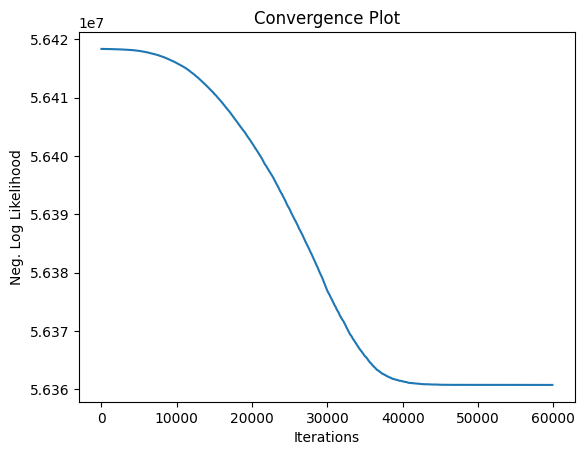

In [6]:
import matplotlib.pyplot as plt

plt.plot(reg.neg_log_likelihood)

plt.title('Convergence Plot')
plt.ylabel('Neg. Log Likelihood')
plt.xlabel('Iterations')

plt.show()

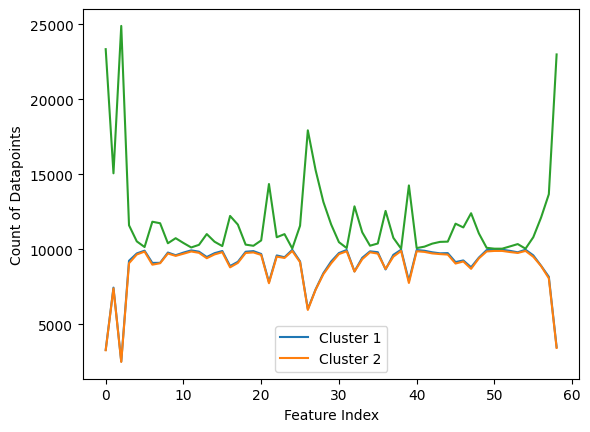

In [7]:
plt.plot(reg.cluster_feature_count.T)

plt.ylabel('Count of Datapoints')
plt.xlabel('Feature Index')

plt.legend(['Cluster 1', 'Cluster 2'])
plt.show()

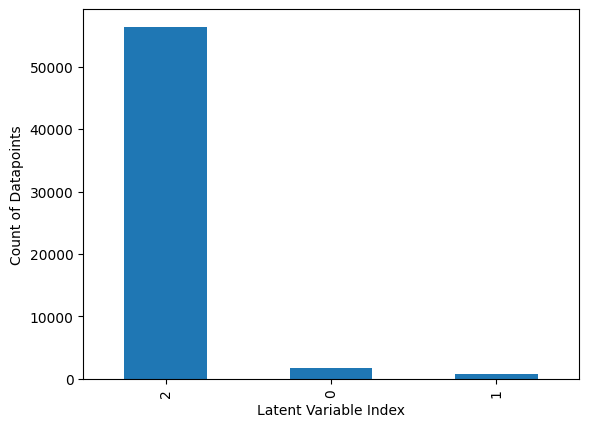

In [8]:
pd.Series(reg.trace[1000:]).value_counts().plot(kind='bar')

plt.ylabel('Count of Datapoints')
plt.xlabel('Latent Variable Index')

plt.show()

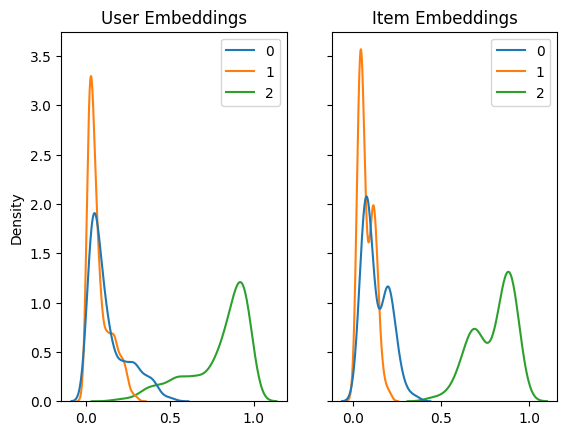

In [18]:
user_embs = reg.transform(X, idx=data.index.get_level_values('user_id'))
item_embs = reg.transform(X, idx=data.index.get_level_values('item_id'))

import seaborn as sns
fig, ax = plt.subplots(1, 2, sharey=True)
sns.kdeplot(user_embs, ax=ax[0])
sns.kdeplot(item_embs, ax=ax[1])

ax[0].set_title('User Embeddings')
ax[1].set_title('Item Embeddings')
plt.show()

In [27]:
# # get user, item similarity matrix
# user_item_sims = pd.DataFrame(
#     user_embs @ item_embs.T / np.linalg.norm(user_embs) / np.linalg.norm(item_embs)
# )
# user_item_sims.index = data.index.get_level_values('user_id')
# user_item_sims.columns = data.index.get_level_values('item_id')

# user_item_sims.T.idxmax().value_counts().head(10)[::-1].plot(kind='barh')

# plt.title('First Recommendation Counts')
# plt.ylabel('Movie Index')
# plt.xlabel('No. of Recommedations')
# plt.show()

In [20]:
# 50 / 50 split
n = 5 * len(data) // 10
X_train = data.drop('rating', axis=1)[:n]
X_test = data.drop('rating', axis=1)[n:]

y_train = data.rating[:n]
y_test = data.rating[n:]

In [24]:
from src.replayer import replayer
play = replayer(reg)

play.fit(X_train, y_train)
ratings = play.test(X_test, y_test)

/Users/marialentini/Library/CloudStorage/OneDrive-PearsonPLC/Research/MCMC/notebooks/../src/replayer.py:123: PerformanceWarning: indexing past lexsort depth may impact performance.
  x = data.loc[user_id, item_id].to_numpy()
/Users/marialentini/Library/CloudStorage/OneDrive-PearsonPLC/Research/MCMC/notebooks/../src/replayer.py:123: PerformanceWarning: indexing past lexsort depth may impact performance.
  x = data.loc[user_id, item_id].to_numpy()
/Users/marialentini/Library/CloudStorage/OneDrive-PearsonPLC/Research/MCMC/notebooks/../src/replayer.py:123: PerformanceWarning: indexing past lexsort depth may impact performance.
  x = data.loc[user_id, item_id].to_numpy()
/Users/marialentini/Library/CloudStorage/OneDrive-PearsonPLC/Research/MCMC/notebooks/../src/replayer.py:123: PerformanceWarning: indexing past lexsort depth may impact performance.
  x = data.loc[user_id, item_id].to_numpy()
/Users/marialentini/Library/CloudStorage/OneDrive-PearsonPLC/Research/MCMC/notebooks/../src/replayer

In [25]:
print('Average MovieLens 100K Rating:', y_test.mean())
print('Test: Recommendations made:', len(ratings))
print('Test: Average Rating of Recs:', np.mean(ratings))

Average MovieLens 100K Rating: 0.6544166778030202
Test: Recommendations made: 206
Test: Average Rating of Recs: 0.8543689320388349
